#### Note - this data cleaning is associated with the data used for the mini-batch resnet model only.

## Cleaning Image Data
- I will initially be resizing the input image suche that it be updated from  1080x720 to 720x720. This was chosen such that the image can then be divided into 15x15 cells, with each cell having a width and height of 48 pixels. Further, I will be making the images grayscale as this model only needs to learn the difference between a closed and open palm, which I believe is unrelated to color. Finally, I will be standardizing the pixels and doubling the dataset through image augmentation.

- I created 200 training examples, 100 with a closed palm and 100 with an open palm. I collected the (x,y) corresponding with the upper left region along with the width and height of the bounding box within the image.

- As stated earlier, 15x15 is the size of the output grid. The channel of each cell will be 1x7 and correspond with [is_obj_in_cell,x_mid, y_mid, width, height, prob_open_palm, prob_closed_palm]
 
- X_train shape = (720,720,1) 
- y_train shape = (15,15,7)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import latex
import os
import cv2
from skimage.transform import resize
from PIL import Image
import math

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Goes through the data encoding and saves the information for each image in a dictionary
atype = open/close
"""
def get_encoding_data(path,data_dict,atype):
    with open(path+"data.txt") as file:
        lines = file.readlines()
        for line in lines:
            split_line = line.split(" ") #data delineated by spaces
            data_dict[atype+split_line[0]] = {"x1":int(split_line[1]),"y1":int(split_line[2]),"width":int(split_line[3]),"height":int(split_line[4])}
            
        return data_dict

In [3]:
encoding_dict = {}
close_path = "../../palm_data/close_palm/" 
open_path = "../../palm_data/open_palm/"

encoding_dict = get_encoding_data(close_path,encoding_dict,"close")
encoding_dict = get_encoding_data(open_path,encoding_dict,"open")

In [4]:
"""
Scales the image to (720, 720)
Turns the image into grayscale
Returns image of shape (720,720,1)
"""
def transform_image(path,file):
    img = cv2.imread(path+file,cv2.IMREAD_GRAYSCALE) # grayscaled
    img = cv2.resize(img, (720,720), interpolation = cv2.INTER_AREA) # scaled
    img = np.array(img)
    img.shape = (720,720,1)
    return img

In [5]:
"""
Updates the bounding box coordinates such that they work in (720,720) resolution after interpolation
Returns the updated encoding for a given image
"""
def update_bounding_box(encoding):
    encode = {}
    xmin = encoding["x1"]
    width = encoding["width"]
    xmax = xmin + width
    
    scale_x = 720 / 1080
    xmin = xmin * scale_x
    xmax = xmax * scale_x
    width = xmax - xmin
    
    encode["x1"] = xmin
    encode["y1"] = encoding["y1"]
    encode["width"] = width
    encode["height"] = encoding["height"]
    return encode

In [6]:
"""
Does horizontal reflection for each image and updates encoding and returns both 
This will ultimately double the size of the dataset
"""
def double_data(img,encoding):
    encode = {}
    xmin = encoding["x1"]
    width = encoding["width"]
    img = np.flip(img, axis=1)
    xmin = 720 - xmin - width
    encode["x1"] = xmin
    encode["y1"] = encoding["y1"]
    encode["height"] = encoding["height"]
    encode["width"] = encoding["width"]
    
    return img,encode

In [7]:
"""
Iterates through images, saving images and their encodings after transformations
"""
def get_all_data(path,encoding_dict):
    encoding_list = [] 
    image_list = []
    for file in os.listdir(path): # iterating through images
        if ".jpg" in file: # image
            img = transform_image(path, file)
            encoding = encoding_dict[file.replace("_","").split(".")[0]] # get encoding
            encoding = update_bounding_box(encoding) # fix bounding box coordinates after image scaling
            image_list.append(img)
            encoding_list.append(encoding)
            
            img,new_encoding = double_data(img,encoding) # horizontal reflection
            image_list.append(img)
            encoding_list.append(new_encoding)

    return encoding_list,image_list

In [8]:
encoding_list = []
image_list = []

In [9]:
encoding_list1,image_list1 = get_all_data(close_path,encoding_dict)
encoding_list2,image_list2 = get_all_data(open_path,encoding_dict)
encoding_list = encoding_list1 + encoding_list2
image_list = image_list1 + image_list2

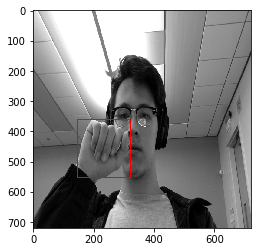

number of images 396
number of encodings 396


In [10]:
# Testing the image encodings

img = image_list[108]
img.shape = (720,720,)
encodings = encoding_list[108]
xmin = encodings["x1"]
ymin = encodings["y1"]
width = encodings["width"]
height = encodings["height"]

fig,ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((xmin,ymin),width,height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.imshow(img, cmap = 'gray')
plt.show()
print("number of images",len(image_list))
print("number of encodings",len(encoding_list))

### Seeing how many clusters the images are naturally grouped into

There should be two clusters because the bounding boxes are either corresponding with an open or closed palm which essentially has the ratio regardless of the training example.

In [11]:
widths = []
heights = []
for i in range(len(encoding_list)):
    widths.append(encoding_list[i]["width"])
    heights.append(encoding_list[i]["height"])

# First 198 are closed and the remained are open palm
labels = [0 for i in range(198)] + [1 for i in range(198)] # closed or open palm

In [12]:
# Data for sklearn kmeans clustering
wh_data = np.array([widths,heights]).T

In [13]:
widths_open = widths[198:]
widths_closed = widths[:198]
heights_open = heights[198:]
heights_closed = heights[:198]
assert(len(heights_open)==198)
assert(len(heights_closed)==198)

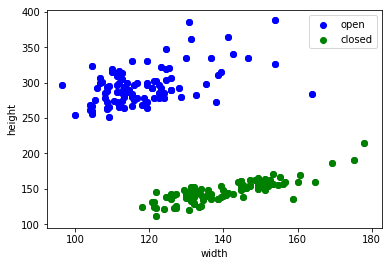

In [14]:
# There are two clear clusters
plt.scatter(widths_open,heights_open,c="blue",label="open")
plt.scatter(widths_closed,heights_closed,c="green",label="closed")
plt.xlabel("width")
plt.ylabel("height")
plt.legend()
plt.show()

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(2).fit(wh_data)

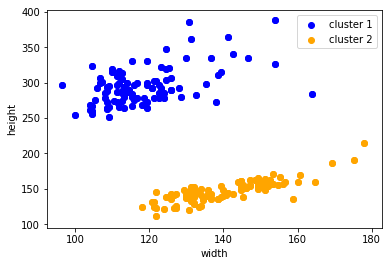

In [16]:
# Getting clusters and plotting them
# As we can see the two clusters are based on whether the palm is open or closed
# Theoretically we could create more clusters, but I believe this is unecessary
labels = list(kmeans.labels_)
widths_cluster_1 = [widths[i] for i in range(len(labels)) if labels[i] == 1]
heights_cluster_1 = [heights[i] for i in range(len(labels)) if labels[i] == 1]
widths_cluster_0 = [widths[i] for i in range(len(labels)) if labels[i] == 0]
heights_cluster_0 = [heights[i] for i in range(len(labels)) if labels[i] == 0]

plt.scatter(widths_cluster_1,heights_cluster_1,c="blue",label="cluster 1")
plt.scatter(widths_cluster_0,heights_cluster_0,c="orange",label="cluster 2")
plt.xlabel("width")
plt.ylabel("height")
plt.legend()
plt.show()

### Finishing the encoding of the data 
x1, y1, height, and width need to be encoded as values in relation to the cell they are located in. The final output of the encodings for each image will be of shape (15,15,7). As stated earlier, each (1,1,7) chunk will be composed of [is_obj_in_cell,x_mid, y_mid, width, height, prob_open_palm, prob_closed_palm].

In [17]:
pixels_per_cell = int(720 / 15)
print("pixels per cell:",pixels_per_cell)

pixels per cell: 48


In [18]:
final_encodings = []

In [19]:
# Creating a list of updated encodings
for i in range(len(encoding_list)):
    encode = np.zeros((15,15,7)) # Initialize final encoding
    enc = encoding_list[i]
    x1 = enc["x1"]
    y1 = enc["y1"]
    height = enc["height"]
    width = enc["width"]
    # getting the x and y midpoints
    x_mid = x1 + (1/2*width)
    y_mid = y1 + (1/2*height)
    # which cell the midpoint is in
    cell_x = x_mid // pixels_per_cell
    cell_y = y_mid // pixels_per_cell
    # update x_mid and y_mid to be in relation of cell
    x_mid = (x_mid - (pixels_per_cell * cell_x)) / pixels_per_cell
    y_mid = (y_mid - (pixels_per_cell * cell_y)) / pixels_per_cell
    # change the height and width to be divided by the image height and width
    height = height / 720
    width = width / 720
    # create encoding
    if i < 198: # closed palm
        entry = np.array([1, x_mid, y_mid, width, height, 0, 1])
    else: # open palm
        entry = np.array([1, x_mid, y_mid, width, height, 1, 0])
    encode[int(cell_x),int(cell_y),:] = entry
    final_encodings.append(encode)

In [20]:
# Shuffle the dataset such that it's not all in order 
from sklearn.utils import shuffle
image_list = shuffle(image_list, random_state=10)
final_encodings = shuffle(final_encodings, random_state=10)
assert(len(final_encodings)==396)
assert(len(image_list)==396)

In [21]:
# Printing an example of an encoding
img = image_list[201]
encoding = final_encodings[201]
cells = np.nonzero(encoding[:,:,0]) # Get the index tuple of the encoding
the_encoding = encoding[cells[0][0],cells[1][0],:] 
print("Encoding for this image:",the_encoding)
x_mid = the_encoding[1]
y_mid = the_encoding[2]
width = the_encoding[3]
height = the_encoding[4]
width = width * 720
height = height * 720

x_mid = x_mid * pixels_per_cell + (pixels_per_cell * cells[0][0])
y_mid = y_mid * pixels_per_cell + (pixels_per_cell * cells[1][0])
x_min = x_mid - (1/2*width)
y_min = y_mid - (1/2*height)

x_ticks = np.arange(0, 720, pixels_per_cell)
y_ticks = np.arange(0, 720, pixels_per_cell)
img.shape = (720,720,)

Encoding for this image: [1.         0.78472222 0.8125     0.15092593 0.40833333 1.
 0.        ]


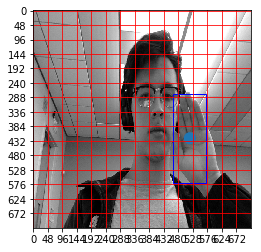

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.grid(which='both',color='r')
ax.imshow(img,cmap = 'gray')
bounding_box = patches.Rectangle((x_min,y_min),width,height,linewidth=1,edgecolor='b',facecolor='none')
midpoint = patches.Circle((x_mid,y_mid), radius=20)
ax.add_patch(bounding_box)
ax.add_patch(midpoint)

plt.show()

In [23]:
# Ensuring the shape of all images are correct
for image in image_list:
    image.shape = (720,720,1)

In [24]:
print("image shape:",image_list[0].shape)
print("encoding shape:",final_encodings[0].shape)
images = np.array(image_list)
encodings = np.array(final_encodings)
print("image data shape:",images.shape)
print("encoding data shape:",encodings.shape)

image shape: (720, 720, 1)
encoding shape: (15, 15, 7)
image data shape: (396, 720, 720, 1)
encoding data shape: (396, 15, 15, 7)


In [25]:
# Saving the encodings and the images
np.save("../../data/dinorunner/images.npy",images)
np.save("../../data/dinorunner/encodings.npy",encodings)